In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import numpy as np
import tempfile
import tensorflow as tf

import tf_rl
from tf_rl.controller import DiscreteDeepQ, HumanController
from tf_rl import simulate
from tf_rl.models import MLP
from maddux.rl_experiments.planning import Planning

In [4]:
LOG_DIR = tempfile.mkdtemp()
print(LOG_DIR)

/tmp/tmp6pG7wg


In [5]:
SAVE_DIR = "/home/colin/robots/maddux/saved_experiments"

In [6]:
game = Planning()

In [7]:
# Tensorflow business - it is always good to reset a graph before creating a new controller.
tf.reset_default_graph()
session = tf.InteractiveSession()

# This little guy will let us run tensorboard
#      tensorboard --logdir [LOG_DIR]
journalist = tf.train.SummaryWriter(LOG_DIR)

# Brain maps from observation to Q values for different actions.
# Here it is a done using a multi layer perceptron with 2 hidden
# layers
brain = MLP([game.observation_size,], [50, 50, game.num_actions], 
            [tf.tanh, tf.tanh, tf.identity])

# The optimizer to use. Here we use RMSProp as recommended
# by the publication
optimizer = tf.train.RMSPropOptimizer(learning_rate= 0.001, decay=0.9)

# DiscreteDeepQ object
current_controller = DiscreteDeepQ(game.observation_size, game.num_actions, brain, 
                                   optimizer, session, discount_rate=0.9, 
                                   exploration_period=5000, max_experience=10000, 
                                   store_every_nth=1, train_every_nth=1,
                                   summary_writer=journalist)

session.run(tf.initialize_all_variables())
session.run(current_controller.target_network_update)
# graph was not available when journalist was created  
journalist.add_graph(session.graph_def)

In [8]:
import time
import matplotlib

iterations_needed = []
total_rewards = []

try:
    for game_idx in range(10000):
        game = Planning()
        game_iterations = 0

        observation = game.observe()
        while game_iterations < 100 and not game.is_over():
            action = current_controller.action(observation)
            reward = game.collect_reward(action)
            new_observation = game.observe()
            current_controller.store(observation, action, reward, new_observation)
            current_controller.training_step()
            observation = new_observation
            game_iterations += 1
        total_rewards.append(sum(game.collected_rewards))
        iterations_needed.append(game_iterations)
        rewards = []
        if game_idx % 25 == 0:
            print "\rGame %d: iterations before success %d." % (game_idx, game_iterations),
            print "Total Rewards: %s" % (sum(game.collected_rewards)),
            print "Last 5 rewards: {}".format(game.collected_rewards[-5:]),
            game.save_path(SAVE_DIR, game_idx)


except KeyboardInterrupt:
    print "Interrupted"

Game 2875: iterations before success 28. Total Rewards: 4.87930668923 Last 5 rewards: [0.33953988580539396, 0.25102215577896692, 0.29334811696863983, 0.21730318839103269, 0.30682473430707513] Interrupted


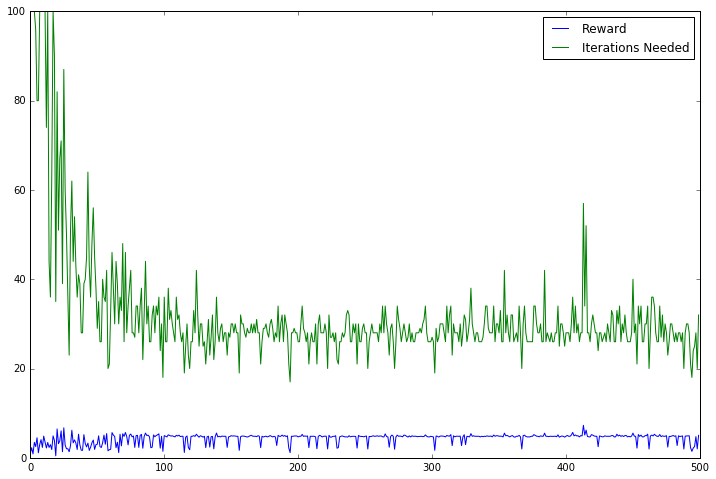

In [9]:
plt.figure(figsize=(12, 8))

plt.plot(total_rewards[0:500], label='Reward')
plt.plot(iterations_needed[0:500], label='Iterations Needed')
plt.legend()

In [10]:
plt.figure(figsize=(12, 12))
sns.jointplot(np.array(iterations_needed), np.array(total_rewards))

NameError: name 'sns' is not defined

In [ ]:
iterations_needed[3000]